# EVpedia analysis

## Import libraries

In [1]:
import gzip
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scikitplot as skplt
import seaborn as sns
import os

from imblearn.under_sampling import RandomUnderSampler
from matplotlib import patches
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from matplotlib_venn import venn2
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Define paths

In [2]:
Data_path = os.path.dirname(os.path.dirname(os.getcwd())) + '/Data'
Model_path = os.path.dirname(os.path.dirname(os.getcwd())) + '/Models'

## Import dataset

### Feature datasets

In [3]:
df_all = pd.read_csv(Data_path + "/curated/features_human_proteome.csv")
df_unfiltered = pd.read_csv(Data_path + '/training/training_data_no_filter.csv', sep=',')
df_MS_iso_filter = pd.read_csv(Data_path + '/training/training_data_MS_iso_filter.csv', sep=',')

### EVpedia

In [4]:
evpedia = pd.read_csv(Data_path + "/raw/evpedia.csv", index_col=0)

### Random Forest models

In [5]:
file = gzip.GzipFile(Model_path + '/EV_RF_model_MS_iso_filter.pkl', 'rb')
rf_3 = pickle.loads(file.read())
file.close()

## Preprocess data

In [6]:
continuous = ['length', 'hydr_count', 'polar_count', 'molecular_weight', 'helix', 'turn', 'sheet', 
    'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 
    'thsa_netsurfp2', 'tasa_netsurfp2', 'rhsa_netsurfp2', 'disorder', 'A_exposed', 'C_exposed', 'D_exposed', 
    'E_exposed', 'F_exposed', 'G_exposed', 'H_exposed', 'I_exposed', 'K_exposed', 'L_exposed', 'M_exposed', 
    'N_exposed', 'P_exposed', 'Q_exposed', 'R_exposed', 'S_exposed', 'T_exposed', 'V_exposed', 'W_exposed', 
    'Y_exposed', 'Probability_solubility', 'Aggregation_propensity', 'Aromaticity', 'Instability_index', 
    'Gravy', 'Isoelectric_point', 'Charge_at_7', 'Charge_at_5', 'Polar_exposed', 'Hydrophobic_exposed']

In [7]:
def preprocess(df):
    
    # define explanatory and response variables
    X = df.drop(["id", "EV"], axis=1)
    y = df["EV"]
    
    # undersample majority class
    undersample = RandomUnderSampler(random_state=0)
    X_balanced, y_balanced = undersample.fit_resample(X, y)
    
    return X_balanced, y_balanced


def split_and_scale(X_balanced, y_balanced, features_cont=continuous, scaler=RobustScaler()):

    # split 80% training and 20% test 
    train_X, test_X, train_y, test_y = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=0, 
        stratify=y_balanced)
    
    # robust scaling
    train_X_scaled = train_X.copy()
    test_X_scaled = test_X.copy()
    train_X_scaled[features_cont] = scaler.fit_transform(train_X[features_cont])
    test_X_scaled[features_cont] = scaler.transform(test_X[features_cont])
    
    print("Size of training set:", len(train_X_scaled))
    print("Size of test set:", len(test_X_scaled))
    
    return train_X_scaled, train_y, test_X_scaled, test_y, scaler

In [8]:
print("Dataset with MS and isolation method filtering")
X_balanced_3, y_balanced_3 = preprocess(df_MS_iso_filter)
train_X_3, train_y_3, test_X_3, test_y_3, scaler_3 = split_and_scale(X_balanced_3, y_balanced_3)

Dataset with MS and isolation method filtering
Size of training set: 9544
Size of test set: 2386


## EVpedia comparison

In [9]:
cutoff = 3

print("Number of human EV proteins in EVpedia:", len(evpedia))
evpedia_filtered = evpedia[evpedia["Identification number"] >= cutoff]
print("Number of human EV proteins in EVpedia with >= %i occurences: %i" %(cutoff, len(evpedia_filtered)))
evpedia_filtered_hp = evpedia_filtered[evpedia_filtered["UniProt accession"].isin(df_all["id"])]
print("Number of filtered EVpedia proteins in human proteome:", len(evpedia_filtered_hp))

Number of human EV proteins in EVpedia: 25118
Number of human EV proteins in EVpedia with >= 3 occurences: 12711
Number of filtered EVpedia proteins in human proteome: 9423


In [10]:
evpedia_val = df_all[df_all["id"].isin(evpedia_filtered_hp["UniProt accession"])]
print("Number of tested proteins:", len(evpedia_val))
X_evpedia = evpedia_val.drop(["id", "fasta_sequence"], axis=1)

X_evpedia[continuous] = scaler_3.transform(X_evpedia[continuous])
print("Sensitivity:", round(rf_3.predict(X_evpedia).sum()/len(X_evpedia)*100, 2))
# compared to sensitivity of 73% during testing (small drop)

Number of tested proteins: 9423
Sensitivity: 67.06


676


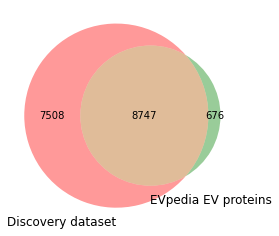

In [11]:
venn2([set(df_MS_iso_filter["id"]), set(evpedia_filtered_hp["UniProt accession"])], 
    ("Discovery dataset", "EVpedia EV proteins"))

novel_evpedia_proteins = set(evpedia_filtered_hp["UniProt accession"]) - set(df_MS_iso_filter["id"])
print(len(novel_evpedia_proteins))

In [12]:
evpedia_val = df_all[df_all["id"].isin(novel_evpedia_proteins)]
print("Number of tested proteins:", len(evpedia_val))
X_evpedia = evpedia_val.drop(["id", "fasta_sequence"], axis=1)

X_evpedia[continuous] = scaler_3.transform(X_evpedia[continuous])
print("Sensitivity:", round(rf_3.predict(X_evpedia).sum()/len(X_evpedia)*100, 2))

Number of tested proteins: 676
Sensitivity: 41.27


In [13]:
filtered_out_EV_proteins = set(df_unfiltered[df_unfiltered["EV"] == 1]["id"]) - \
    set(df_MS_iso_filter[df_MS_iso_filter["EV"] == 1]["id"])

print("Number of proteins that are included in unfiltered EV protein set but not discovery dataset:", 
    len(filtered_out_EV_proteins))

Number of proteins that are included in unfiltered EV protein set but not discovery dataset: 2447


229


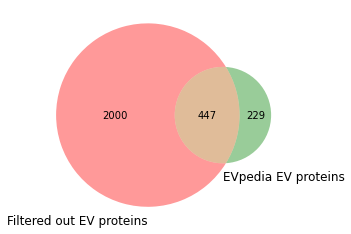

In [14]:
venn2([filtered_out_EV_proteins, novel_evpedia_proteins], 
    ("Filtered out EV proteins", "EVpedia EV proteins"))

novel_evpedia_EV_proteins = novel_evpedia_proteins - filtered_out_EV_proteins
print(len(novel_evpedia_EV_proteins))

In [15]:
evpedia_val = df_all[df_all["id"].isin(novel_evpedia_EV_proteins)]
print("Number of tested proteins:", len(evpedia_val))
X_evpedia = evpedia_val.drop(["id", "fasta_sequence"], axis=1)

X_evpedia[continuous] = scaler_3.transform(X_evpedia[continuous])
print("Sensitivity:", round(rf_3.predict(X_evpedia).sum()/len(X_evpedia)*100, 2))

Number of tested proteins: 229
Sensitivity: 17.03
